In [1]:
import sys, platform, tensorflow as tf
print(sys.executable)
print(platform.python_version())
print(tf.__version__)


c:\Desktop\Bot-Lot dataset\.venv\Scripts\python.exe
3.12.0
2.20.0


In [1]:
# Core
import pandas as pd
import numpy as np 

# ML & preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, f1_score, precision_score, recall_score

# Imbalance
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

# Deep learning
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional

In [5]:


paths = [
    r"C:\Desktop\BOT-LOT DATASET\data\UNSW_2018_IoT_Botnet_Full5pc_1.csv",
    r"C:\Desktop\BOT-LOT DATASET\data\UNSW_2018_IoT_Botnet_Full5pc_2.csv",
    r"C:\Desktop\BOT-LOT DATASET\data\UNSW_2018_IoT_Botnet_Full5pc_3.csv",
    r"C:\Desktop\BOT-LOT DATASET\data\UNSW_2018_IoT_Botnet_Full5pc_4.csv"
]

dfs = [pd.read_csv(p, low_memory=False) for p in paths]
df = pd.concat(dfs, ignore_index=True)

In [6]:
df.shape

(3668522, 46)

In [7]:
df.head()

,pkSeqID,stime,flgs,flgs_number,proto,proto_number,saddr,sport,daddr,dport,...,AR_P_Proto_P_DstIP,N_IN_Conn_P_DstIP,N_IN_Conn_P_SrcIP,AR_P_Proto_P_Sport,AR_P_Proto_P_Dport,Pkts_P_State_P_Protocol_P_DestIP,Pkts_P_State_P_Protocol_P_SrcIP,attack,category,subcategory
0,1,1.528089e+09,e,1,tcp,1,192.168.100.147,49960,192.168.100.7,80,...,1.12704,96,75,1.133720,1.129970,770,602,1,DoS,HTTP
1,2,1.528089e+09,e,1,arp,2,192.168.100.7,-1,192.168.100.147,-1,...,15267.20000,1,2,0.005142,0.005142,2,6,1,DoS,HTTP
2,3,1.528089e+09,e,1,tcp,1,192.168.100.147,49962,192.168.100.7,80,...,1.12704,96,75,1.135100,1.129970,770,602,1,DoS,HTTP
3,4,1.528089e+09,e,1,tcp,1,192.168.100.147,49964,192.168.100.7,80,...,1.12704,96,75,1.135140,1.129970,770,602,1,DoS,HTTP
4,5,1.528089e+09,e,1,tcp,1,192.168.100.147,49966,192.168.100.7,80,...,1.12704,96,75,1.135260,1.129970,770,602,1,DoS,HTTP


In [8]:
df.columns.tolist()

['pkSeqID',
 'stime',
 'flgs',
 'flgs_number',
 'proto',
 'proto_number',
 'saddr',
 'sport',
 'daddr',
 'dport',
 'pkts',
 'bytes',
 'state',
 'state_number',
 'ltime',
 'seq',
 'dur',
 'mean',
 'stddev',
 'sum',
 'min',
 'max',
 'spkts',
 'dpkts',
 'sbytes',
 'dbytes',
 'rate',
 'srate',
 'drate',
 'TnBPSrcIP',
 'TnBPDstIP',
 'TnP_PSrcIP',
 'TnP_PDstIP',
 'TnP_PerProto',
 'TnP_Per_Dport',
 'AR_P_Proto_P_SrcIP',
 'AR_P_Proto_P_DstIP',
 'N_IN_Conn_P_DstIP',
 'N_IN_Conn_P_SrcIP',
 'AR_P_Proto_P_Sport',
 'AR_P_Proto_P_Dport',
 'Pkts_P_State_P_Protocol_P_DestIP',
 'Pkts_P_State_P_Protocol_P_SrcIP',
 'attack',
 'category',
 'subcategory']

In [9]:
# Missing values
print(df.isnull().sum().sort_values(ascending=False).head(10))

pkSeqID         0
stime           0
flgs            0
flgs_number     0
proto           0
proto_number    0
saddr           0
sport           0
daddr           0
dport           0
dtype: int64


In [33]:
# Count unique labels in the attack column
df['attack'].value_counts()

attack
1    3668045
0        477
Name: count, dtype: int64

In [10]:
[col for col in df.columns if 'label' in col.lower()
 or 'attack' in col.lower()
 or 'class' in col.lower()
 or 'category' in col.lower()]

['attack', 'category', 'subcategory']

In [11]:
drop_cols = ['pkSeqID', 'stime', 'saddr', 'daddr']  # IPs & sequence IDs

In [12]:
feature_list = [
    'proto', 'state', 'flgs',                   # categorical
    'pkts', 'bytes', 'dur', 'spkts', 'dpkts', 'sbytes', 'dbytes', 'mean', 'stddev',
    'sum', 'min', 'max', 'ltime', 'seq',
    'AR_P_Proto_P_DstIP', 'N_IN_Conn_P_DstIP', 'N_IN_Conn_P_SrcIP',
    'AR_P_Proto_P_Sport', 'AR_P_Proto_P_Dport',
    'Pkts_P_State_P_Protocol_P_DestIP', 'Pkts_P_State_P_Protocol_P_SrcIP',
    'pkts/s', 'bytes/s', 'average_p', 'var_p', 'med_p', 'q1_p', 'q3_p', 'iqr_p',
    'some_other_numeric1', 'some_other_numeric2', 'some_other_numeric3',
    'some_other_numeric4', 'some_other_numeric5', 'some_other_numeric6',
]  # adjust numeric features to match your dataset columns

In [13]:

from sklearn.preprocessing import MinMaxScaler, LabelEncoder

# Example selected features
categorical_features = ['proto', 'state', 'flgs']  # adjust if needed
numeric_features = [
    'pkts', 'bytes', 'dur', 'spkts', 'dpkts', 'sbytes', 'dbytes',
    'mean', 'stddev', 'sum', 'min', 'max', 'ltime', 'seq',
    'AR_P_Proto_P_DstIP', 'N_IN_Conn_P_DstIP', 'N_IN_Conn_P_SrcIP',
    'AR_P_Proto_P_Sport', 'AR_P_Proto_P_Dport',
    'Pkts_P_State_P_Protocol_P_DestIP', 'Pkts_P_State_P_Protocol_P_SrcIP',
    'average_p', 'var_p', 'med_p', 'q1_p', 'q3_p', 'iqr_p'
]  # total 40 after combining numeric + categorical

In [15]:
print(df.columns.tolist())

['pkSeqID', 'stime', 'flgs', 'flgs_number', 'proto', 'proto_number', 'saddr', 'sport', 'daddr', 'dport', 'pkts', 'bytes', 'state', 'state_number', 'ltime', 'seq', 'dur', 'mean', 'stddev', 'sum', 'min', 'max', 'spkts', 'dpkts', 'sbytes', 'dbytes', 'rate', 'srate', 'drate', 'TnBPSrcIP', 'TnBPDstIP', 'TnP_PSrcIP', 'TnP_PDstIP', 'TnP_PerProto', 'TnP_Per_Dport', 'AR_P_Proto_P_SrcIP', 'AR_P_Proto_P_DstIP', 'N_IN_Conn_P_DstIP', 'N_IN_Conn_P_SrcIP', 'AR_P_Proto_P_Sport', 'AR_P_Proto_P_Dport', 'Pkts_P_State_P_Protocol_P_DestIP', 'Pkts_P_State_P_Protocol_P_SrcIP', 'attack', 'category', 'subcategory']


In [16]:
categorical_features = ['proto', 'state', 'flgs']

In [17]:
numeric_features = [
    'pkts', 'bytes', 'dur', 'spkts', 'dpkts', 'sbytes', 'dbytes',
    'rate', 'srate', 'drate', 'TnBPSrcIP', 'TnBPDstIP', 'TnP_PSrcIP',
    'TnP_PDstIP', 'TnP_PerProto', 'TnP_Per_Dport',
    'AR_P_Proto_P_SrcIP', 'AR_P_Proto_P_DstIP',
    'N_IN_Conn_P_DstIP', 'N_IN_Conn_P_SrcIP',
    'AR_P_Proto_P_Sport', 'AR_P_Proto_P_Dport',
    'Pkts_P_State_P_Protocol_P_DestIP', 'Pkts_P_State_P_Protocol_P_SrcIP'
]

In [18]:
y = df['attack'].map({'Normal': 0, 'Attack': 1})

In [19]:
X = df[numeric_features + categorical_features].copy()
print("Selected features shape:", X.shape)
X.head()

Selected features shape: (3668522, 27)


,pkts,bytes,dur,spkts,dpkts,sbytes,dbytes,rate,srate,drate,...,AR_P_Proto_P_DstIP,N_IN_Conn_P_DstIP,N_IN_Conn_P_SrcIP,AR_P_Proto_P_Sport,AR_P_Proto_P_Dport,Pkts_P_State_P_Protocol_P_DestIP,Pkts_P_State_P_Protocol_P_SrcIP,proto,state,flgs
0,8,1980,7.056393,5,3,650,1330,0.992008,0.566862,14.511893,...,1.12704,96,75,1.133720,1.129970,770,602,tcp,RST,e
1,2,120,0.000131,1,1,60,60,7633.588379,0.000000,0.000000,...,15267.20000,1,2,0.005142,0.005142,2,6,arp,CON,e
2,8,2126,7.047852,5,3,796,1330,0.993210,0.567549,15.505319,...,1.12704,96,75,1.135100,1.129970,770,602,tcp,RST,e
3,8,2024,7.047592,5,3,694,1330,0.993247,0.567570,15.578993,...,1.12704,96,75,1.135140,1.129970,770,602,tcp,RST,e
4,8,2319,7.046841,5,3,989,1330,0.993353,0.567630,15.652637,...,1.12704,96,75,1.135260,1.129970,770,602,tcp,RST,e


Encode Categorical Features & Scale Numeric Features

In [20]:
from sklearn.preprocessing import MinMaxScaler, LabelEncoder

# 1️⃣ Encode categorical features
for col in categorical_features:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])

# 2️⃣ Scale numeric features
scaler = MinMaxScaler()
X[numeric_features] = scaler.fit_transform(X[numeric_features])

# Check the result
X.head()

,pkts,bytes,dur,spkts,dpkts,sbytes,dbytes,rate,srate,drate,...,AR_P_Proto_P_DstIP,N_IN_Conn_P_DstIP,N_IN_Conn_P_SrcIP,AR_P_Proto_P_Sport,AR_P_Proto_P_Dport,Pkts_P_State_P_Protocol_P_DestIP,Pkts_P_State_P_Protocol_P_SrcIP,proto,state,flgs
0,0.000100,2.672856e-05,2.546069e-03,0.000114,0.000086,1.610725e-05,0.000039,9.920080e-07,5.668620e-07,0.000247,...,0.000001,0.959596,0.747475,3.779067e-07,5.649850e-07,0.006833,0.005096,3,8,0
1,0.000014,8.352674e-07,4.726708e-08,0.000000,0.000029,4.768594e-07,0.000002,7.633588e-03,0.000000e+00,0.000000,...,0.015267,0.000000,0.010101,1.714143e-09,2.571215e-09,0.000009,0.000042,0,1,0
2,0.000100,2.876104e-05,2.542988e-03,0.000114,0.000086,1.997511e-05,0.000039,9.932100e-07,5.675490e-07,0.000264,...,0.000001,0.959596,0.747475,3.783667e-07,5.649850e-07,0.006833,0.005096,3,8,0
3,0.000100,2.734109e-05,2.542894e-03,0.000114,0.000086,1.727291e-05,0.000039,9.932470e-07,5.675700e-07,0.000265,...,0.000001,0.959596,0.747475,3.783800e-07,5.649850e-07,0.006833,0.005096,3,8,0
4,0.000100,3.144782e-05,2.542623e-03,0.000114,0.000086,2.508810e-05,0.000039,9.933530e-07,5.676300e-07,0.000266,...,0.000001,0.959596,0.747475,3.784200e-07,5.649850e-07,0.006833,0.005096,3,8,0


In [21]:
import numpy as np

sequence_length = 50

# Map attack labels: Normal → 0, Attack → 1
y = df['attack'].map({'Normal': 0}).fillna(
    1).astype(int).values  # anything not Normal is 1

# Create sequences
X_seq = []
y_seq = []

for i in range(0, len(X) - sequence_length + 1, sequence_length):
    X_seq.append(X.iloc[i:i+sequence_length].values)
    y_seq.append(1 if y[i:i+sequence_length].sum() > 0 else 0)

X_seq = np.array(X_seq)
y_seq = np.array(y_seq)

print("Sequences shape:", X_seq.shape)
print("Labels shape:", y_seq.shape)


Sequences shape: (73370, 50, 27)
Labels shape: (73370,)


In [31]:
import numpy as np

# Suppose sequences: X, labels: y
# y was constructed as 1 if any attack in sequence, else 0
# Make sure both classes exist
unique, counts = np.unique(y, return_counts=True)
print(dict(zip(unique, counts)))

{np.int64(1): np.int64(3668522)}


In [32]:
from sklearn.model_selection import train_test_split

# Stratified split ensures both classes appear in train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Train shape:", X_train.shape, y_train.shape)
print("Test shape:", X_test.shape, y_test.shape)

Train shape: (2934817, 27) (2934817,)
Test shape: (733705, 27) (733705,)


In [22]:
import pandas as pd

# Flatten sequences to save as CSV if needed
X_flat = X_seq.reshape(-1, X_seq.shape[2])
y_repeat = np.repeat(y_seq, sequence_length)

df_eval = pd.DataFrame(X_flat, columns=X.columns)
df_eval['attack'] = y_repeat

df_eval.to_csv("bot_iot_eval.csv", index=False)

In [23]:
import json

feature_list = X.columns.tolist()
with open("feature_list.json", "w") as f:
    json.dump(feature_list, f)

In [25]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.model_selection import train_test_split

# 1️⃣ Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_seq, y_seq, test_size=0.2, random_state=42, stratify=y_seq)

# 2️⃣ Define CTM-LSTM model
model = Sequential([
    LSTM(128, input_shape=(X_seq.shape[1],
         X_seq.shape[2]), return_sequences=True),
    BatchNormalization(),
    LSTM(64),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')  # binary classification
])

model.compile(optimizer='adam', loss='binary_crossentropy',
              metrics=['accuracy'])

c:\Desktop\Bot-Lot dataset\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [26]:
summary = model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 50, 128)        │        79,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 50, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 131,905 (515.25 KB)

 Trainable params: 131,649 (514.25 KB)

 Non-trainable params: 256 (1.00 KB)

In [27]:
# 3️⃣ Callbacks for training
checkpoint = ModelCheckpoint(
    'ctm_lstm_model.h5', monitor='val_accuracy', save_best_only=True, verbose=1)
early_stop = EarlyStopping(
    monitor='val_loss', patience=5, restore_best_weights=True)

In [28]:
# 4️⃣ Train
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=15,
    batch_size=64,
    callbacks=[checkpoint, early_stop]
)


Epoch 1/15
918/918 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 0.9934 - loss: 0.0254
Epoch 1: val_accuracy improved from None to 1.00000, saving model to ctm_lstm_model.h5


918/918 ━━━━━━━━━━━━━━━━━━━━ 176s 163ms/step - accuracy: 0.9991 - loss: 0.0048 - val_accuracy: 1.0000 - val_loss: 1.0212e-05
Epoch 2/15
918/918 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 1.0000 - loss: 1.9830e-05
Epoch 2: val_accuracy did not improve from 1.00000
918/918 ━━━━━━━━━━━━━━━━━━━━ 187s 149ms/step - accuracy: 1.0000 - loss: 1.3978e-05 - val_accuracy: 1.0000 - val_loss: 1.6990e-06
Epoch 3/15
918/918 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - accuracy: 1.0000 - loss: 4.7755e-06
Epoch 3: val_accuracy did not improve from 1.00000
918/918 ━━━━━━━━━━━━━━━━━━━━ 157s 165ms/step - accuracy: 1.0000 - loss: 3.7943e-06 - val_accuracy: 1.0000 - val_loss: 5.5744e-07
Epoch 4/15
917/918 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - accuracy: 1.0000 - loss: 2.1337e-06
Epoch 4: val_accuracy did not improve from 1.00000
918/918 ━━━━━━━━━━━━━━━━━━━━ 152s 166ms/step - accuracy: 1.0000 - loss: 1.6950e-06 - val_accuracy: 1.0000 - val_loss: 2.1622e-07
Epoch 5/15
918/918 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - acc

In [30]:
from sklearn.metrics import confusion_matrix
import os

# Create results folder if it does not exist
os.makedirs("results", exist_ok=True)

# Confusion matrix fix

conf_matrix = confusion_matrix(y_test, y_pred, labels=[0, 1])

# Only compute ROC-AUC if there are both classes
if len(np.unique(y_test)) > 1:
    roc_auc = roc_auc_score(y_test, y_pred_prob)
else:
    roc_auc = None

# Save metrics
metrics = {
    "accuracy": float(accuracy_score(y_test, y_pred)),
    "f1_score": float(f1_score(y_test, y_pred)),
    "roc_auc": roc_auc,
    "confusion_matrix": conf_matrix.tolist()
}

with open("results/bot_eval.json", "w") as f:
    json.dump(metrics, f, indent=4)

print("Evaluation complete. Metrics saved to results/bot_eval.json")

Evaluation complete. Metrics saved to results/bot_eval.json


In [34]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


In [35]:
selected_features = df[feature_list]  # 27 features

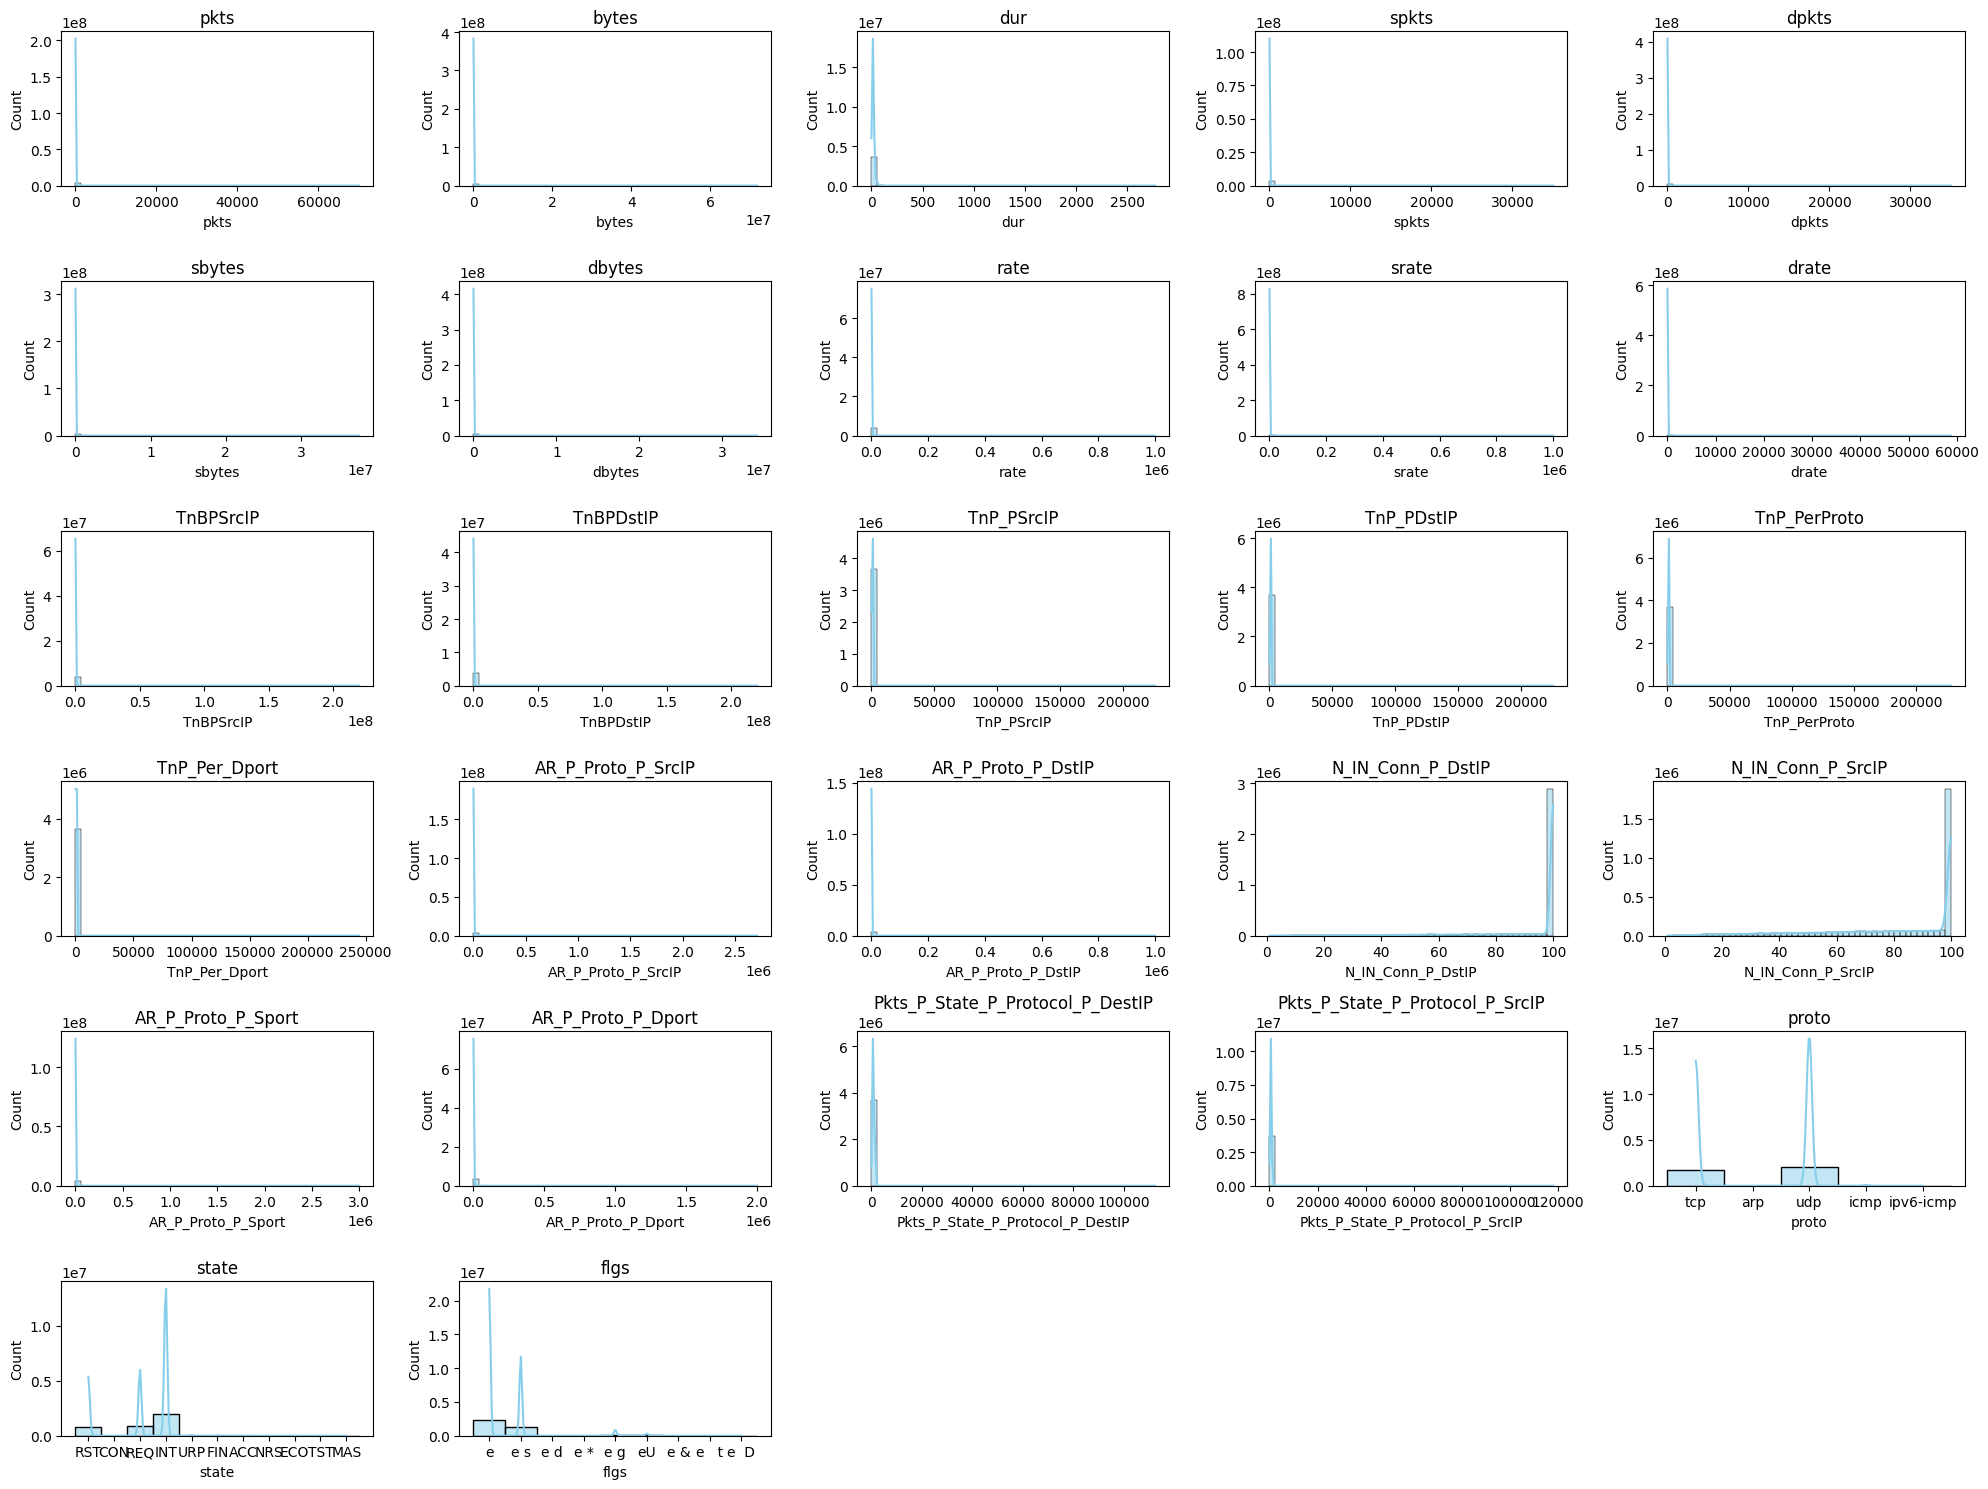

In [37]:

plt.figure(figsize=(20, 15))
for i, col in enumerate(selected_features.columns):
    plt.subplot(6, 5, i+1)
    sns.histplot(selected_features[col], bins=50, kde=True, color='skyblue')
    plt.title(col)

plt.tight_layout()
plt.show()
